In [1]:
import cv2
from PIL import Image 
import time

def to_pil(cv_img):
    img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)
import numpy as np
import math
import os
os.chdir("../")
from tools.image import draw_umich_gaussian

In [ ]:
/home/agent/deep-learning-works/result/msmt duke cuhk01 cuhk02 cuhk03

In [2]:
root = "/home/agent/deep-learning-works/result/msmt duke cuhk01 cuhk02 cuhk03/OSNet_IAP-msmt_duke_cuhk123-amsoftmax-AdamW_amsgrad_lr_0.0015_freeze_step-imagenet"
n_folders = len([f for f in os.scandir(root) if f.is_dir()])

In [9]:
os.path.join(root, sorted(os.listdir(root))[-1])

'/home/agent/deep-learning-works/result/msmt duke cuhk01 cuhk02 cuhk03/OSNet_IAP-msmt_duke_cuhk123-amsoftmax-AdamW_amsgrad_lr_0.0015_freeze_step-imagenet/001-2020-05-12_05-36'

In [21]:
a / np.linalg.norm(a, axis=1, keepdims=True).repeat(2, axis=1)

array([[0.70710678, 0.70710678],
       [0.70710678, 0.70710678]])

In [41]:

num_pts = 6
w, h = 1920, 1080
is_ploygon = True
heat = np.zeros((h, w))
gaussian = draw_umich_gaussian(heat, (w//2-1,h//2-1), int(w)).T
max_radius = h//4
r = np.random.randint(0,h//2, num_pts)
r = np.repeat(r.reshape(-1,1), repeats=2, axis=1)
theta = np.random.randint(0, 360, num_pts) / 180 * math.pi
theta.sort()
if not is_ploygon:
    pts = (r * np.vstack([np.cos(theta), np.sin(theta)]).T + np.repeat(np.array([[w//2-1], [h//2-1]]), num_pts, axis=1).T).astype(int)
else:
    pts = (r * np.vstack([np.cos(theta), np.sin(theta)]).T + np.repeat(np.array([[w//2-1], [h//2-1]]), num_pts, axis=1).T).astype(int)

In [29]:
def generate_pts(w, h, num_pts, is_ploygon, r=None, theta=None):
    assert num_pts > 1

    if r is None:
        r = np.random.randint(0,h//2, num_pts)
    else:
        r = np.array(r)
    r = np.repeat(r.reshape(-1,1), repeats=2, axis=1)
    if theta is None:
        theta = np.random.randint(0, 360, num_pts) / 180 * math.pi
    else:
        theta = np.array(theta) / 180 * math.pi
    theta.sort()
    if not is_ploygon:
        pts = (r * np.vstack([np.cos(theta), np.sin(theta)]).T + np.repeat(np.array([[w//2-1], [h//2-1]]), num_pts, axis=1).T).astype(int)
    else:
        assert num_pts > 2
        pts = (r * np.vstack([np.cos(theta), np.sin(theta)]).T + np.repeat(np.array([[w//2-1], [h//2-1]]), num_pts, axis=1).T).astype(int)
    return pts

def get_ellipse_angle(vec):
    vec = vec / (np.linalg.norm(vec, axis=0, keepdims=True) + 1e-6)
    quadrant_x, quadrant_y = vec > 0
    phi = (np.arccos(-vec[0]) / math.pi * 180).astype(int)
    phi = np.clip(phi, 0, 360)
    if quadrant_x > 0:
        if quadrant_y > 0:  
            angle = 360 - phi
        else:
            angle = phi
    else:
        if quadrant_y > 0:  
            angle = -phi
        else:
            angle = phi
    return angle

def get_ellipse_end_angle(end, vec1, vec2):
    vec1 = vec1 / (np.linalg.norm(vec1, axis=0, keepdims=True) + 1e-6)
    vec2 = vec2 / (np.linalg.norm(vec2, axis=0, keepdims=True) + 1e-6) 
    theta = (np.arccos(np.dot(vec1, vec2)) / math.pi * 180).astype(int) 
    theat = np.clip(theta, 0, 360)
    det = np.linalg.det(np.vstack([vec1, vec2]))
    if det > 0:
        end_angle = 180 + theta
    elif det < 0:
        end_angle = 180 - theta
    else:
        end_angle = 180
    return end_angle

def get_gaussian_weight(w, h, radius):
    heat = np.zeros((h, w))
    gaussian = draw_umich_gaussian(heat, (w//2-1,h//2-1), int(radius)).T
    return gaussian

def build_lines(pts, is_ploygon):
    assert pts.ndim == 2
    assert pts.shape[1] == 2
    assert pts.shape[0] > 1
    lines = np.hstack([pts, np.vstack([pts[1:], pts[0]])]).reshape((-1,2,2))
    if not is_ploygon:
        return lines[:-1]
    return lines

def build_polygon(lines, w, h, gaussian_weight, max_radius):
    regions = []
    # planks = []
    for line_idx, line_pt in enumerate(lines):
        region = np.ones((w,h)) * -1
        plank = np.ones((h,w)).astype(np.uint8) * 255
        start, end = line_pt
        vec1 = end-start
        trace = np.linspace(start, end, 50).astype(int)
        for pt in trace:
            x, y = pt
            weight = gaussian_weight[x, y]
            radius = max_radius * weight
            cv2.circle(plank, (x, y), int(radius), (1), -1)    
        y_pts, x_pts = np.where(plank[...,:]==1)
        for x, y in zip(x_pts, y_pts):
            vec2 = np.array([x, y]) - start
            det = np.linalg.det(np.vstack([vec1, vec2]))
            if det > 0:
                region[x,y] = 0
            elif det < 0:
                region[x,y] = 2
            else:
                region[x,y] = 2
        regions.append(region)
    
    regions = np.array(regions)
    assert len(regions) > 2
    w, h = regions.shape[1:]
    num = len(regions)
    closed = np.ones((h,w)).astype(np.uint8) * 255
    closed = cv2.resize(closed, (w, h))
    pts = lines[:,0].astype(np.int32)
    cv2.fillPoly(closed, [pts], (1,1,1))
    closed = np.transpose(closed, (1,0))
    overlap = regions.sum(axis=0)
    # outer region
    total = np.zeros((w,h))
    # ignore region
    total[overlap==-num] = -1
    # inner region
    total[closed==1] = 1
    return total


def build_segments(pts, lines, w, h, gaussian_weight, max_radius):
    traces = []
    # planks = []
    for line_idx, line_pt in enumerate(lines):
        start, end = line_pt
        num_pt = np.linalg.norm(end-start, axis=0).astype(int)
        traces.append(np.linspace(start, end, num_pt))
    traces = np.vstack(traces)
    traces = np.concatenate([traces[:-2], traces[1:-1], traces[2:]], axis=1).reshape(-1, 3, 2)
    plank = np.ones((h,w)).astype(np.uint8) * 255
    for start, middle, end in traces:
        x, y = middle.astype(int)
        vec1 = middle - start
        vec2 = end - middle
        angle = get_ellipse_angle(vec1)
        end_angle = get_ellipse_end_angle(end, vec1, vec2)          
        weight = gaussian_weight[x, y]
        radius = max_radius * weight
        cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle, 0, end_angle, 0, -1)
        cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle+end_angle, 0, 360-end_angle, 1, -1)
    if len(pts) == 2:
        return plank.T
    assert len(pts) > 2
    traces = np.concatenate([pts[:-2], pts[1:-1], pts[2:]], axis=1).reshape(-1, 3, 2)
    for start, middle, end in traces:
        x, y = middle.astype(int)
        vec1 = middle - start
        vec2 = end - middle
        if np.abs(vec1).sum() == 2 or np.abs(vec2).sum() == 2:
            continue
        angle = get_ellipse_angle(vec1)
        end_angle = get_ellipse_end_angle(end, vec1, vec2)          
        weight = gaussian_weight[x, y]
        radius = max_radius * weight + 5
        cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle, 0, end_angle, 0, -1)
        cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle+end_angle, 0, 360-end_angle, 1, -1)
    return plank.T
       
    
def visualize_region(region_map):
    w, h = region_map.shape
    plain = np.ones((w,h,3))*255
    plain[region_map==-1,:] = 0 #np.array([0,255,255])
    plain[region_map==0,:] = np.array([255,255,0])
    plain[region_map==1,:] = np.array([0,0,255])
    dist = np.transpose(plain, (1,0,2)).astype(np.uint8)
    return to_pil(dist)


In [552]:
np.ones((3,4)).sum(axis=1)

array([4., 4., 4.])

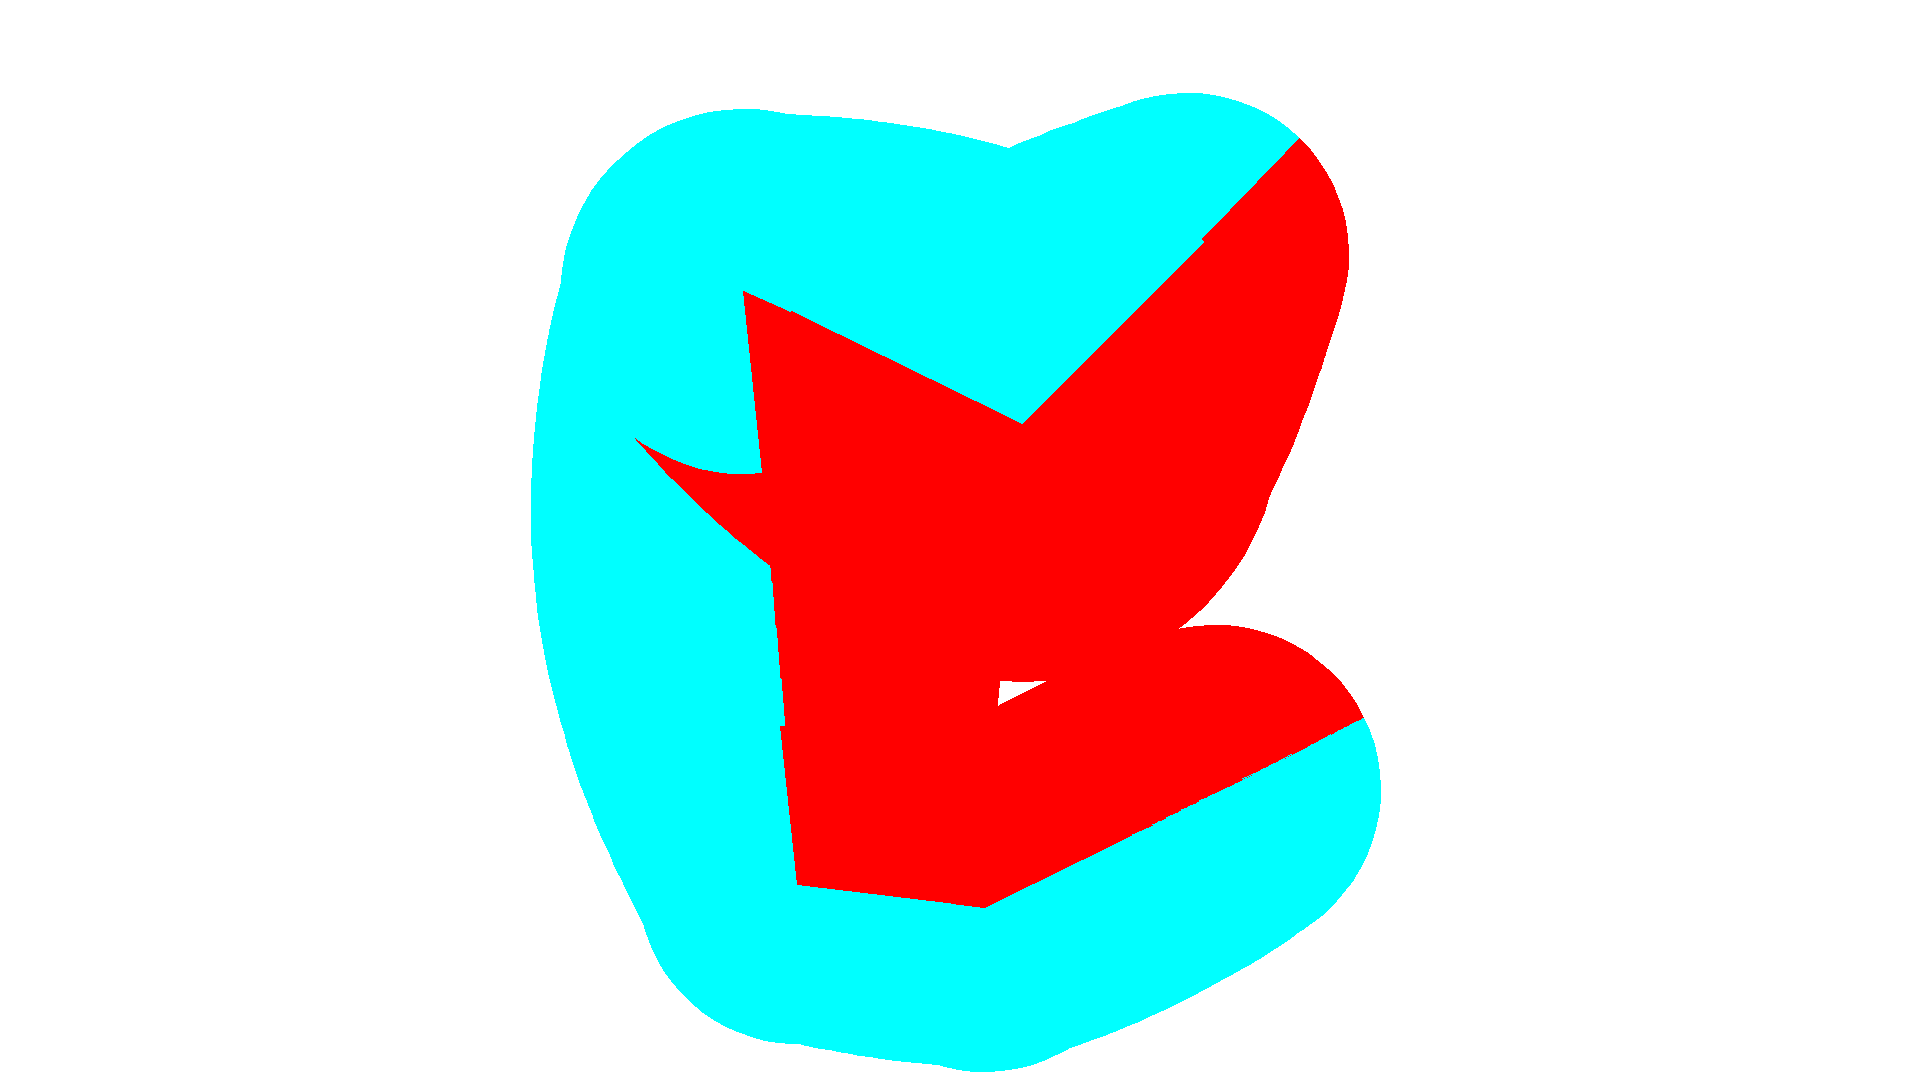

In [550]:
pts = np.array([
    [1000,200],
    [700,600],
    [500,160],
    [100,1000],
    [500,900]
])
w, h = 1920, 1080
pts = generate_pts(w, h, num_pts=6, is_ploygon=False)
# gaussian = get_gaussian_weight(w=w, h=h, radius=h)
lines = build_lines(pts, is_ploygon=False)
img = build_segments(pts, lines, w, h, gaussian, h//4)
# img  = build_regions(lines, w, h, gaussian, h//4)
visualize_region(img)

In [456]:
img = np.array(img).reshape(-1, 2)
np.concatenate([img[1:][::2][:-1], img[::2][1:], img[1:][::2][1:]], axis=1).reshape(-1, 3, 2)

array([[[475, 510],
        [700, 490],
        [700, 344]],

       [[700, 344],
        [700, 200],
        [399, 149]]])

In [451]:
img

array([[250, 530],
       [475, 510],
       [700, 490],
       [700, 344],
       [700, 200],
       [399, 149]])

In [450]:
img[1:][::2]

array([[475, 510],
       [700, 344],
       [399, 149]])

In [198]:
traces = np.concatenate([pts[:-2], pts[1:-1], pts[2:]], axis=1).reshape(-1, 3, 2)

In [207]:
middle

array([700, 200])

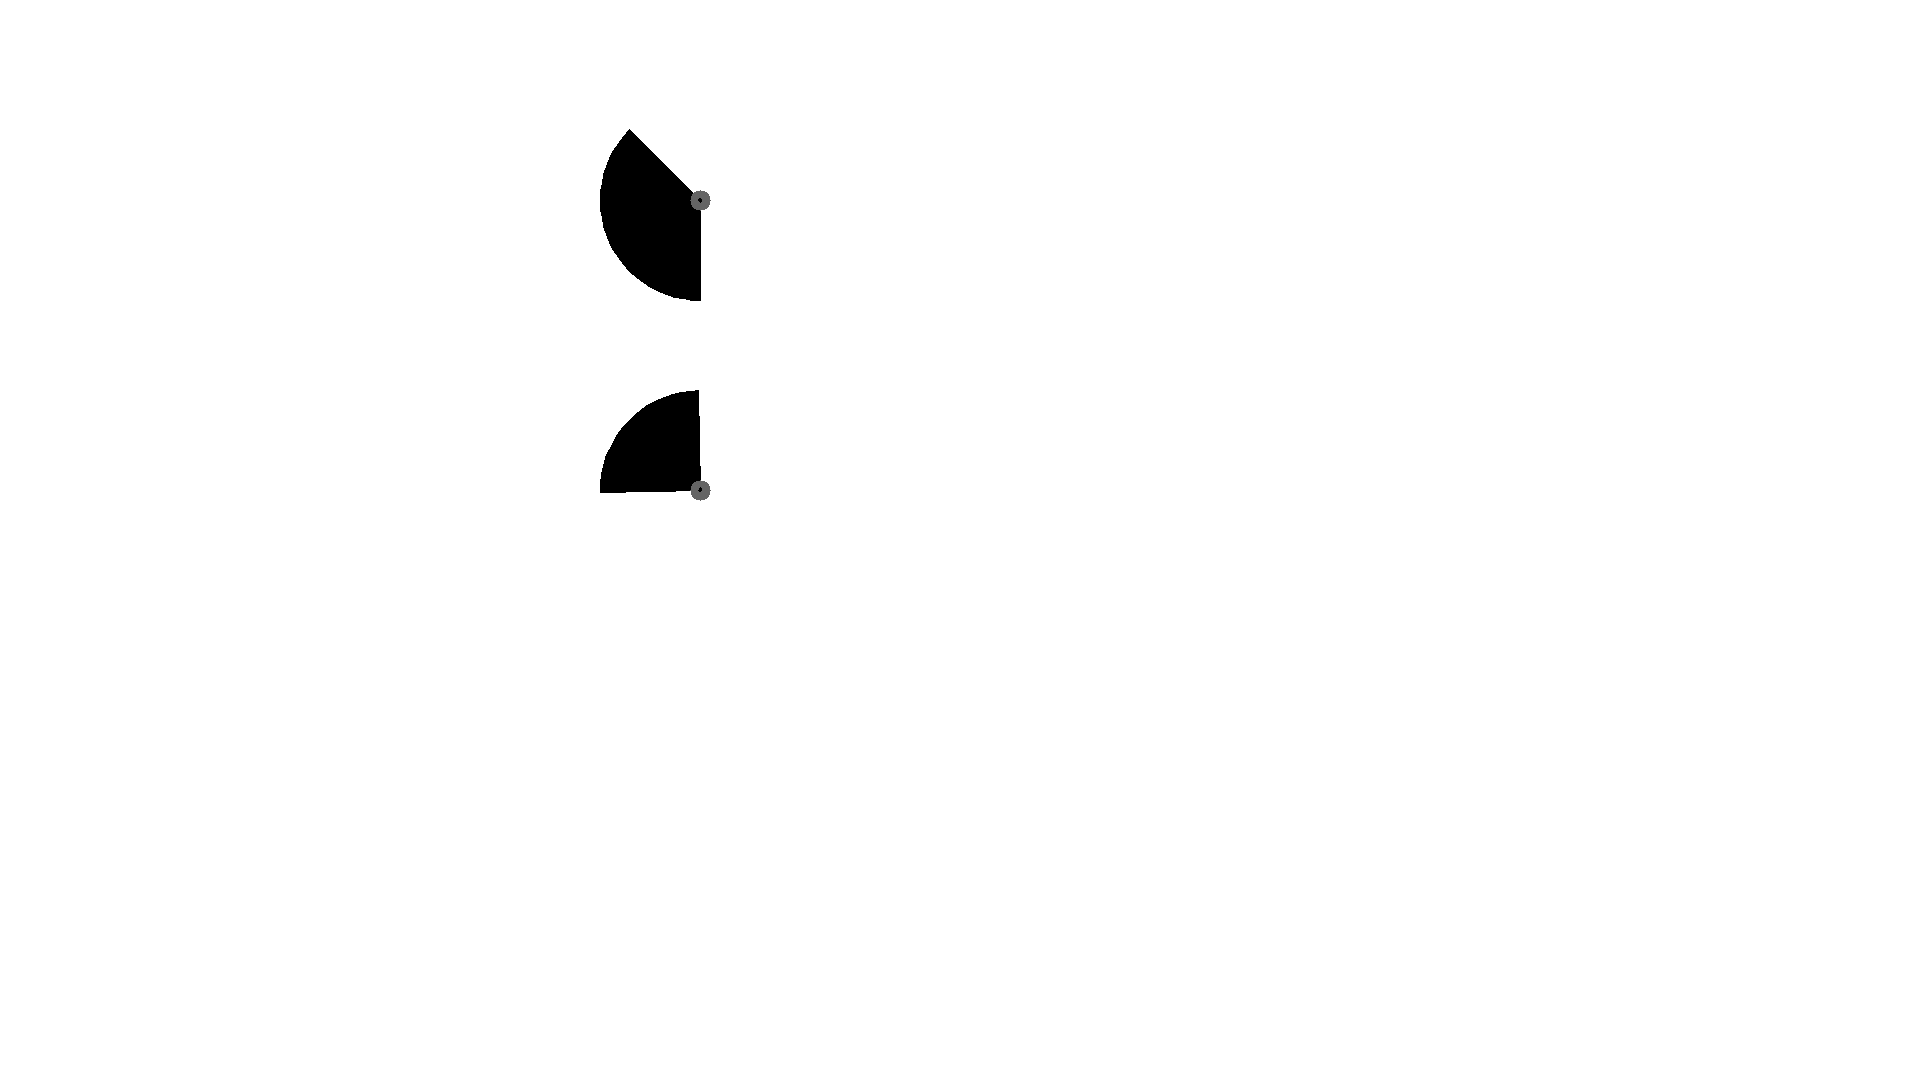

In [423]:
plank = np.ones((h,w)).astype(np.uint8) * 255
plank = cv2.resize(plank, (w, h))
for start, middle, end in img[1]:
    x, y = start
    vec1 = middle - start
    vec2 = end - middle
    angle = get_ellipse_angle(vec1)
    end_angle = get_ellipse_end_angle(end, vec1, vec2)     
    radius = 100
    cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle, 0, end_angle, 0, -1)
    # cv2.ellipse(plank, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle+end_angle, 0, 360-end_angle, 1, -1)
    cv2.circle(plank, (int(middle[0]), int(middle[1])), int(10), (100), -1)
    cv2.line(plank, (int(start[0]), int(start[1])), (int(middle[0]), int(middle[1])), 1, 2)
    cv2.line(plank, (int(middle[0]), int(middle[1])), (int(end[0]), int(end[1])), 1, 2)
to_pil(plank)

In [157]:
normalized_vec1, normalized_vec2

(array([  0.        , -32.02514256]), array([ 33.12945782, -11.04315261]))

In [94]:

a, b = traces[:2]
vec = b - a
normalized_vec = vec / np.linalg.norm(vec, axis=0, keepdims=True)

In [112]:
traces = np.concatenate([traces[:-2], traces[1:-1], traces[2:]], axis=1).reshape(-1, 3, 2)
start, middle, end = traces[1]

In [113]:
x, y = start
vec1 = middle - start
vec2 = end - middle
normalized_vec1 = vec1 / np.linalg.norm(vec, axis=0, keepdims=True)
normalized_vec2 = vec2 / np.linalg.norm(vec, axis=0, keepdims=True) 

In [115]:
traces.dtype

dtype('int64')

In [114]:

(np.arccos(np.dot(normalized_vec1, normalized_vec2)) / math.pi * 180).astype(int) + 1

1.2074182697257333e-06

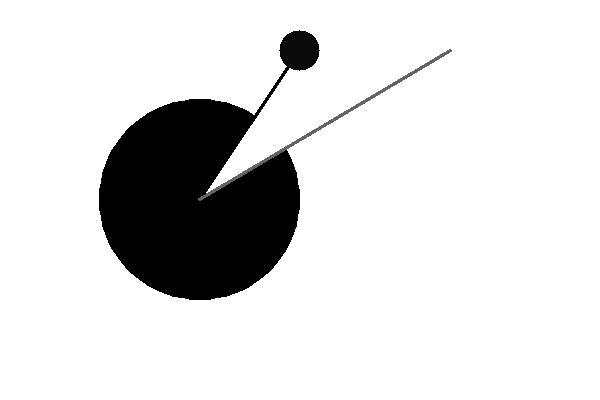

In [298]:
img=np.ones((400, 600)).astype(np.uint8) * 255
start = np.array([299,50])
middle = np.array([199,199])
end = np.array([450,50])
vec1 = middle - start
vec2 = end - middle
angle = get_ellipse_angle(vec1)
end_angle = get_ellipse_end_angle(end, vec1, vec2)
radius=100

cv2.ellipse(img, (int(middle[0]), int(middle[1])), (int(radius), int(radius)), angle+end_angle, 0, 360-end_angle, 1, -1)
cv2.line(img, (int(start[0]), int(start[1])), (int(middle[0]), int(middle[1])), 1, 2)
cv2.line(img, (int(middle[0]), int(middle[1])), (int(end[0]), int(end[1])), 100, 2)
cv2.circle(img, (int(start[0]), int(start[1])), int(20), (10), -1)
to_pil(img)

In [286]:
end_angle

326

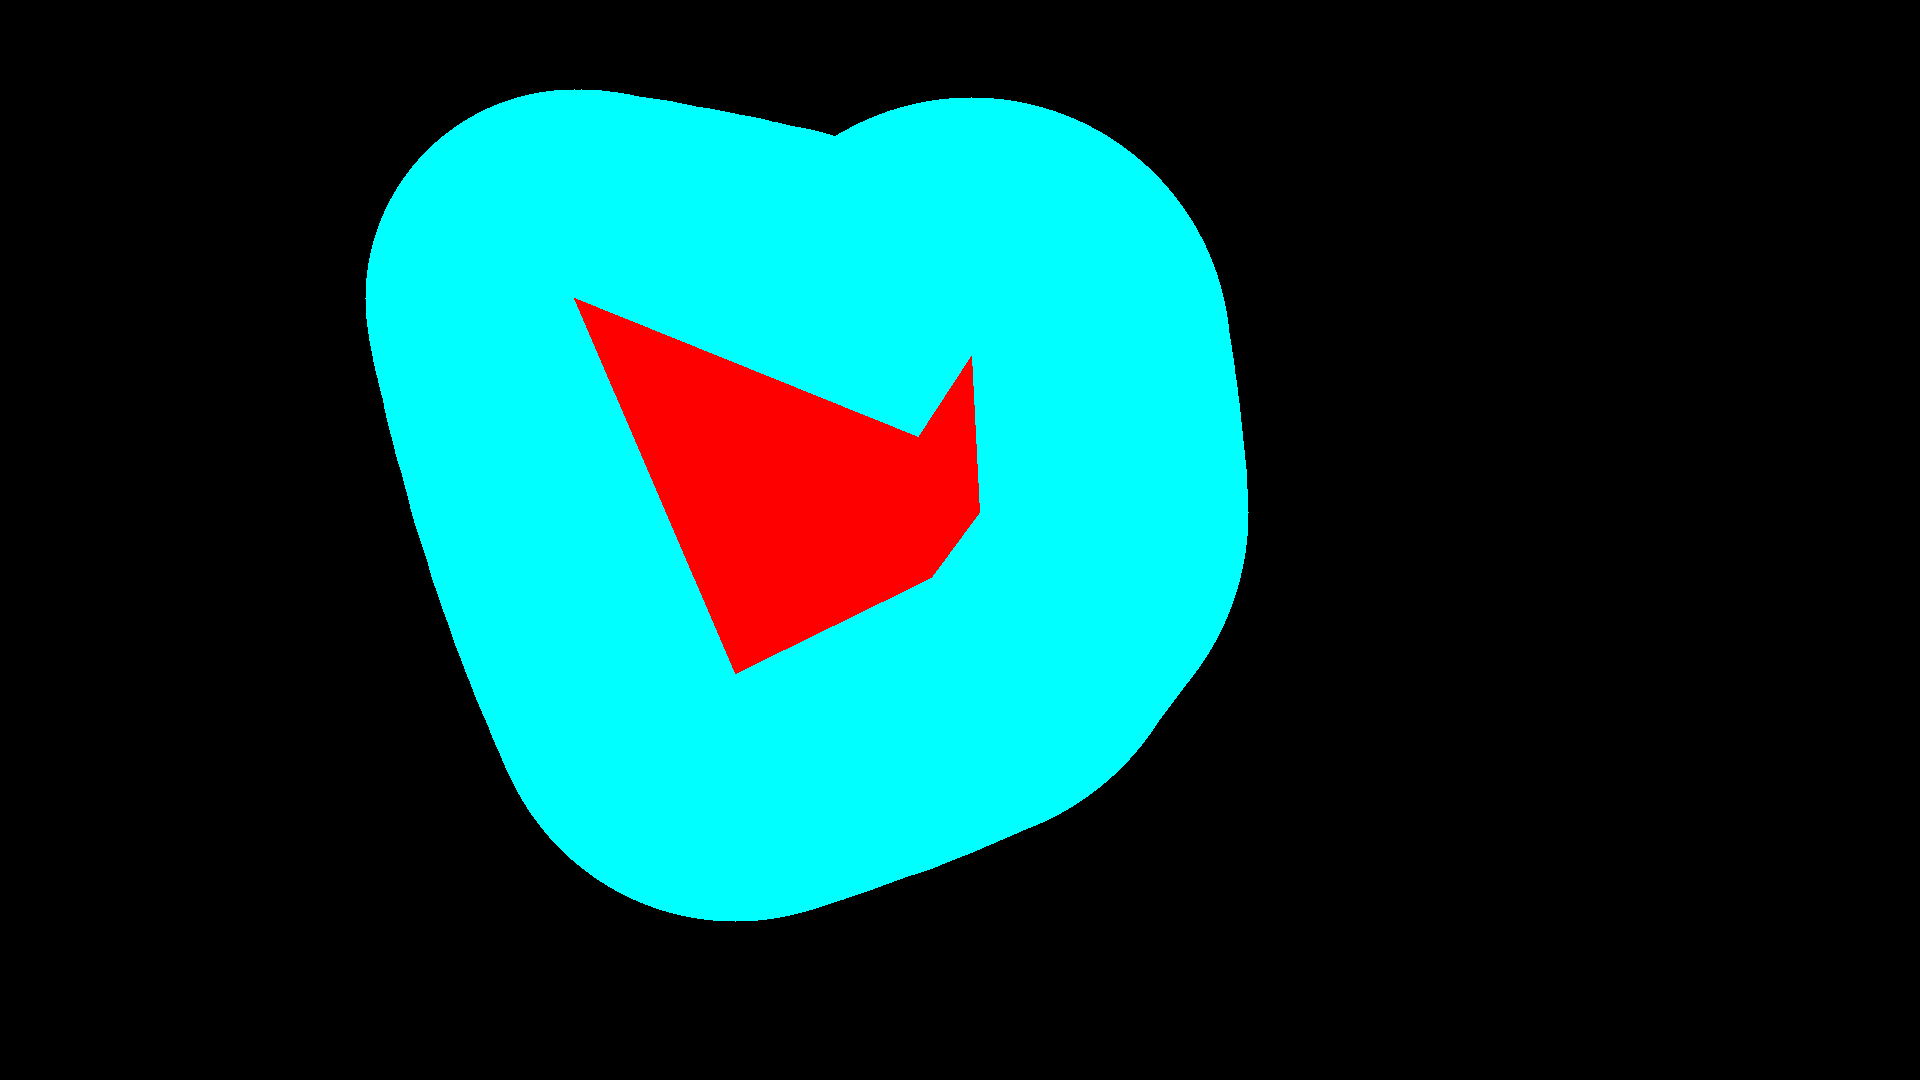

In [43]:

plain = np.ones((w,h,3))*255
plain[region_map==-1,:] = 0
plain[region_map==0,:] = np.array([255,255,0])
plain[region_map==1,:] = np.array([0,0,255])
dist = np.transpose(plain, (1,0,2)).astype(np.uint8)
to_pil(dist)

In [95]:



for line_idx, line_pt in enumerate(lines):
    region = np.ones((w,h)) * -1
    plank = np.ones((h,w,3)).astype(np.uint8) * 255
    start, end = line_pt[0], line_pt[1]
    vec1 = end-start
    line = np.linspace(start, end, 50).astype(int)
    for pt in line:
        x, y = pt
        weight = gaussian[x, y]
        radius = max_radius * weight
        cv2.circle(plank, (x, y), int(radius), (1,1,1), -1)    
    y_pts, x_pts, _ = np.where(plank[...,:]==np.array((1,1,1)))
    for x, y in zip(x_pts, y_pts):
        vec2 = np.array([x, y]) - start
        det = np.linalg.det(np.vstack([vec1, vec2]))
        if det > 0:
            region[x,y] = 0
        elif det < 0:
            region[x,y] = 1
    regions.append(region)
    planks.append(plank)

In [96]:
np.save("../external/test_region_5.npy", np.array(regions))

In [153]:
regions = np.array(regions)
num = len(regions)

In [131]:
plain1 = np.ones((w,h,3))*255
plain1[a==-1,:] = 100

-4.0

In [9]:
lines = np.array([
    [[480,270],[480,810]],
    [[480,810],[1440,810]],
    # [[1440,810],[1440,270]],
    # [[1440,270],[480,270]],
    [[1440,810],[480,270]]
])
lines[:,0]

array([[ 480,  270],
       [ 480,  810],
       [1440,  810]])

In [44]:
total.shape

(3, 1920)

In [97]:
regions = np.load("../external/test_region_5.npy")
num = len(regions)
w, h = regions.shape[1:]
closed = np.ones((h,w,3)).astype(np.uint8) * 255
closed = cv2.resize(closed, (w, h))
pts = lines[:,0].astype(np.int32)
cv2.fillPoly(closed, [pts], (1,1,1))
closed = np.transpose(closed, (2,1,0))[0]
overlap = regions.sum(axis=0)
total = np.zeros((w,h))
total[overlap==-num] = -1
total[closed==1] = 1


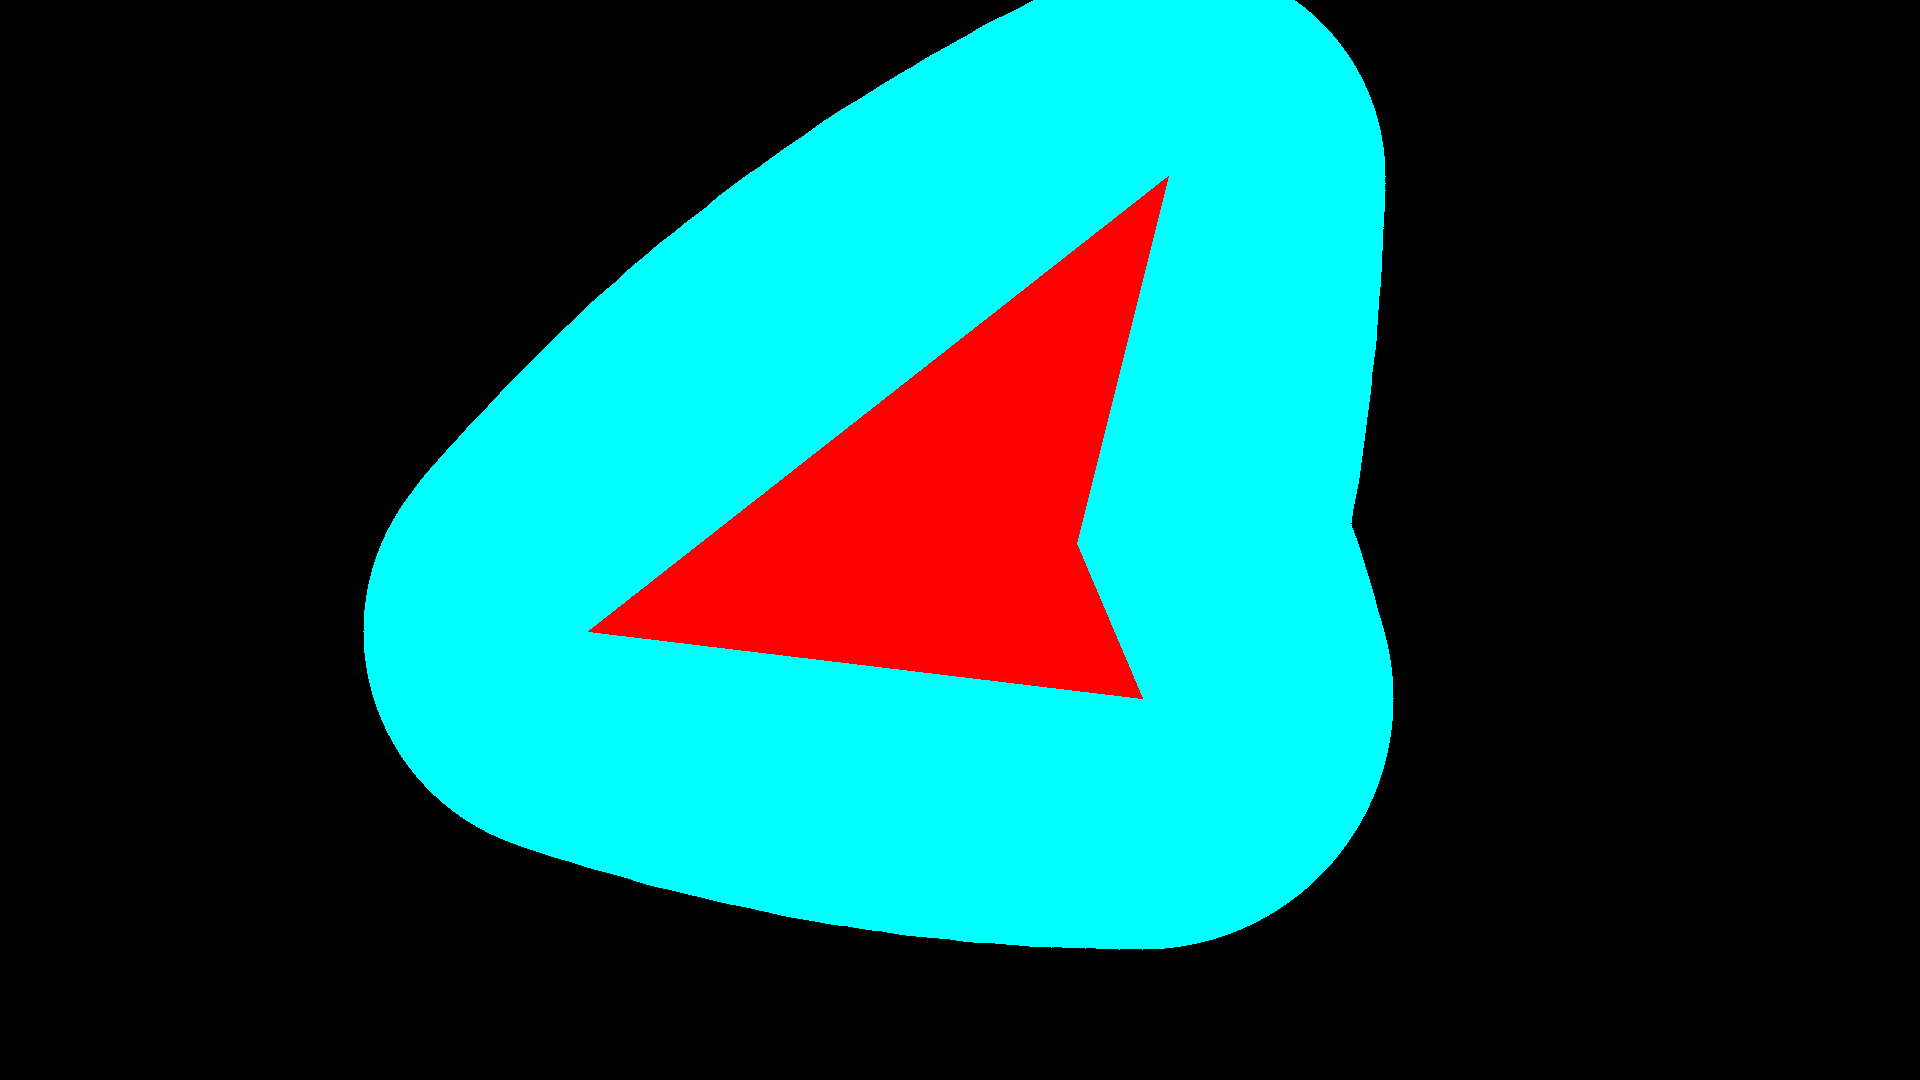

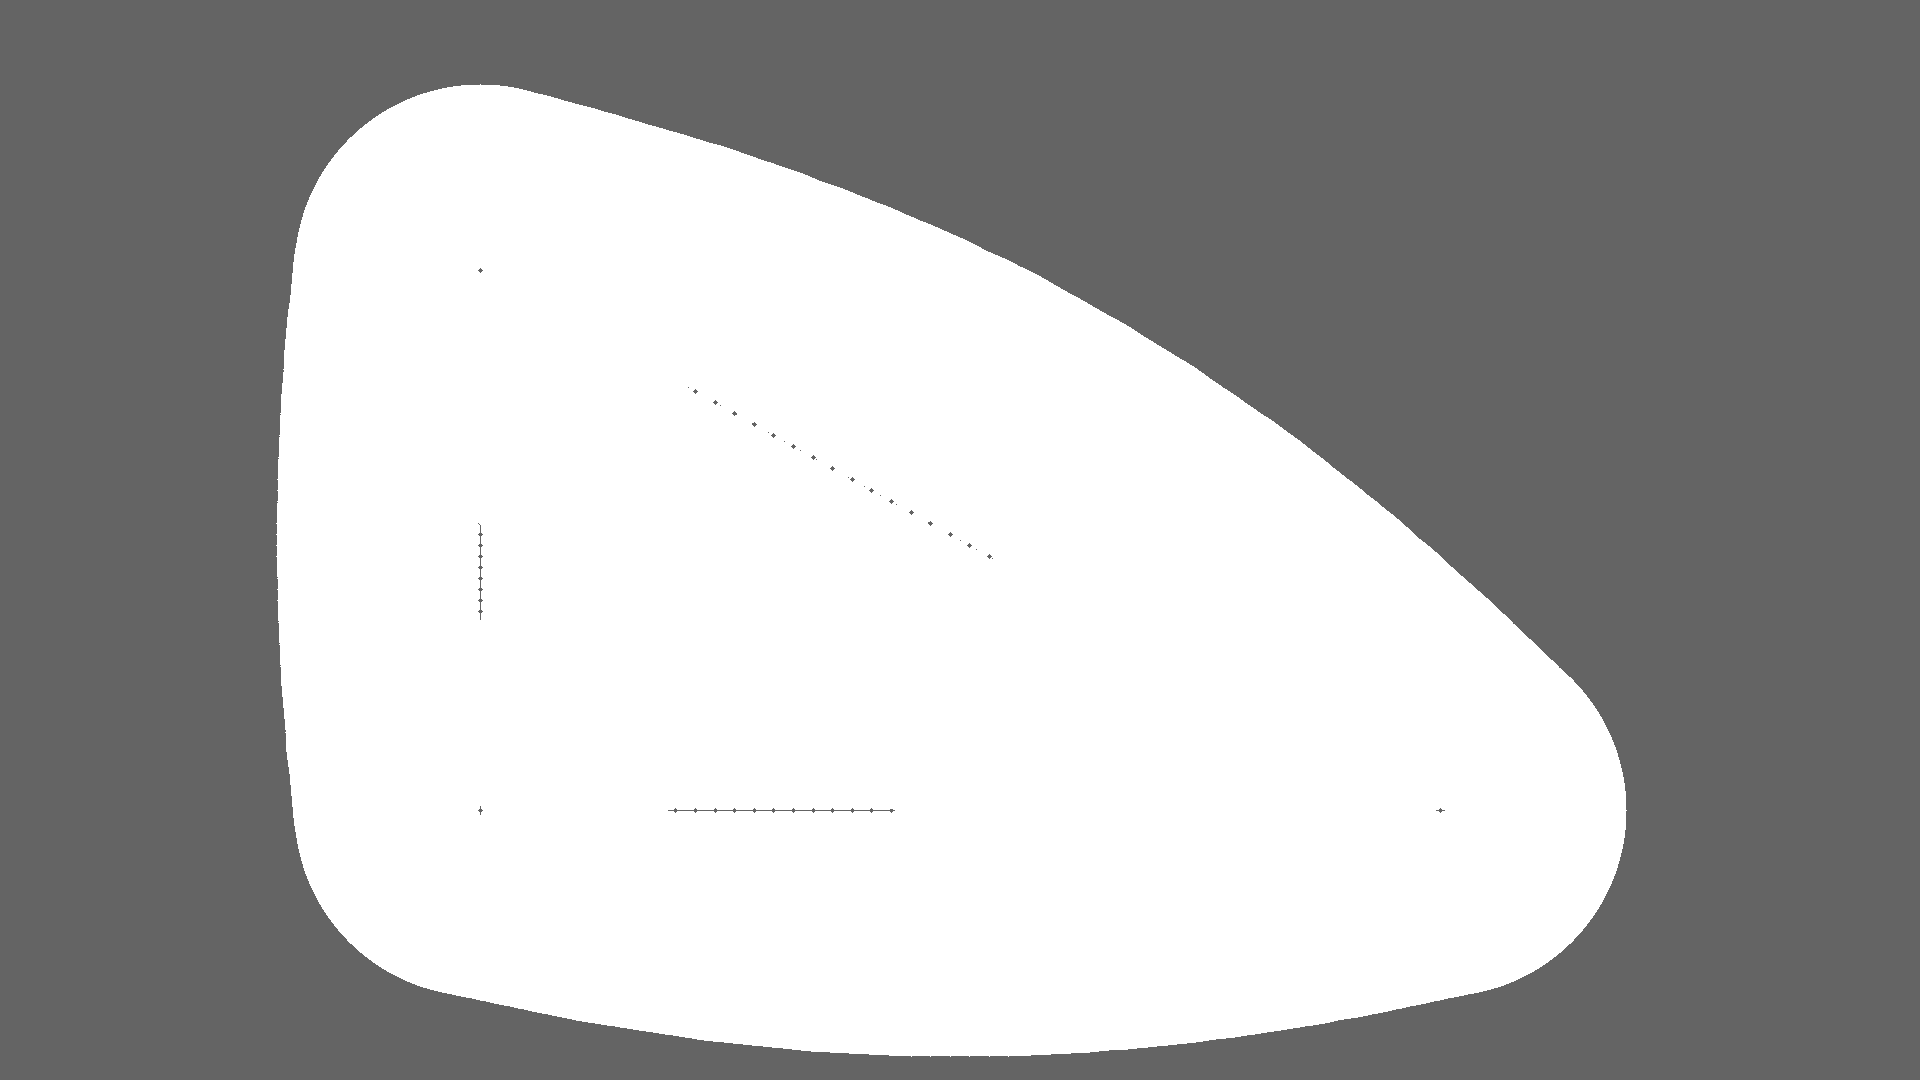

In [53]:
closed = np.ones((h,w,3)).astype(np.uint8) * 255
closed = cv2.resize(closed, (w, h))
pts = lines[:,0].astype(np.int32)
cv2.fillPoly(closed, [pts], (1,1,1))
closed = np.transpose(closed, (2,1,0))[0]
total = np.ones((w,h)) * -1
plain = np.ones((w,h,3))*255
plain[a==-num,:] = 100
# plain[closed==1,:] = 50
dist = np.transpose(plain, (1,0,2)).astype(np.uint8)
to_pil(dist)

In [20]:
a.shape

(1920, 1080)

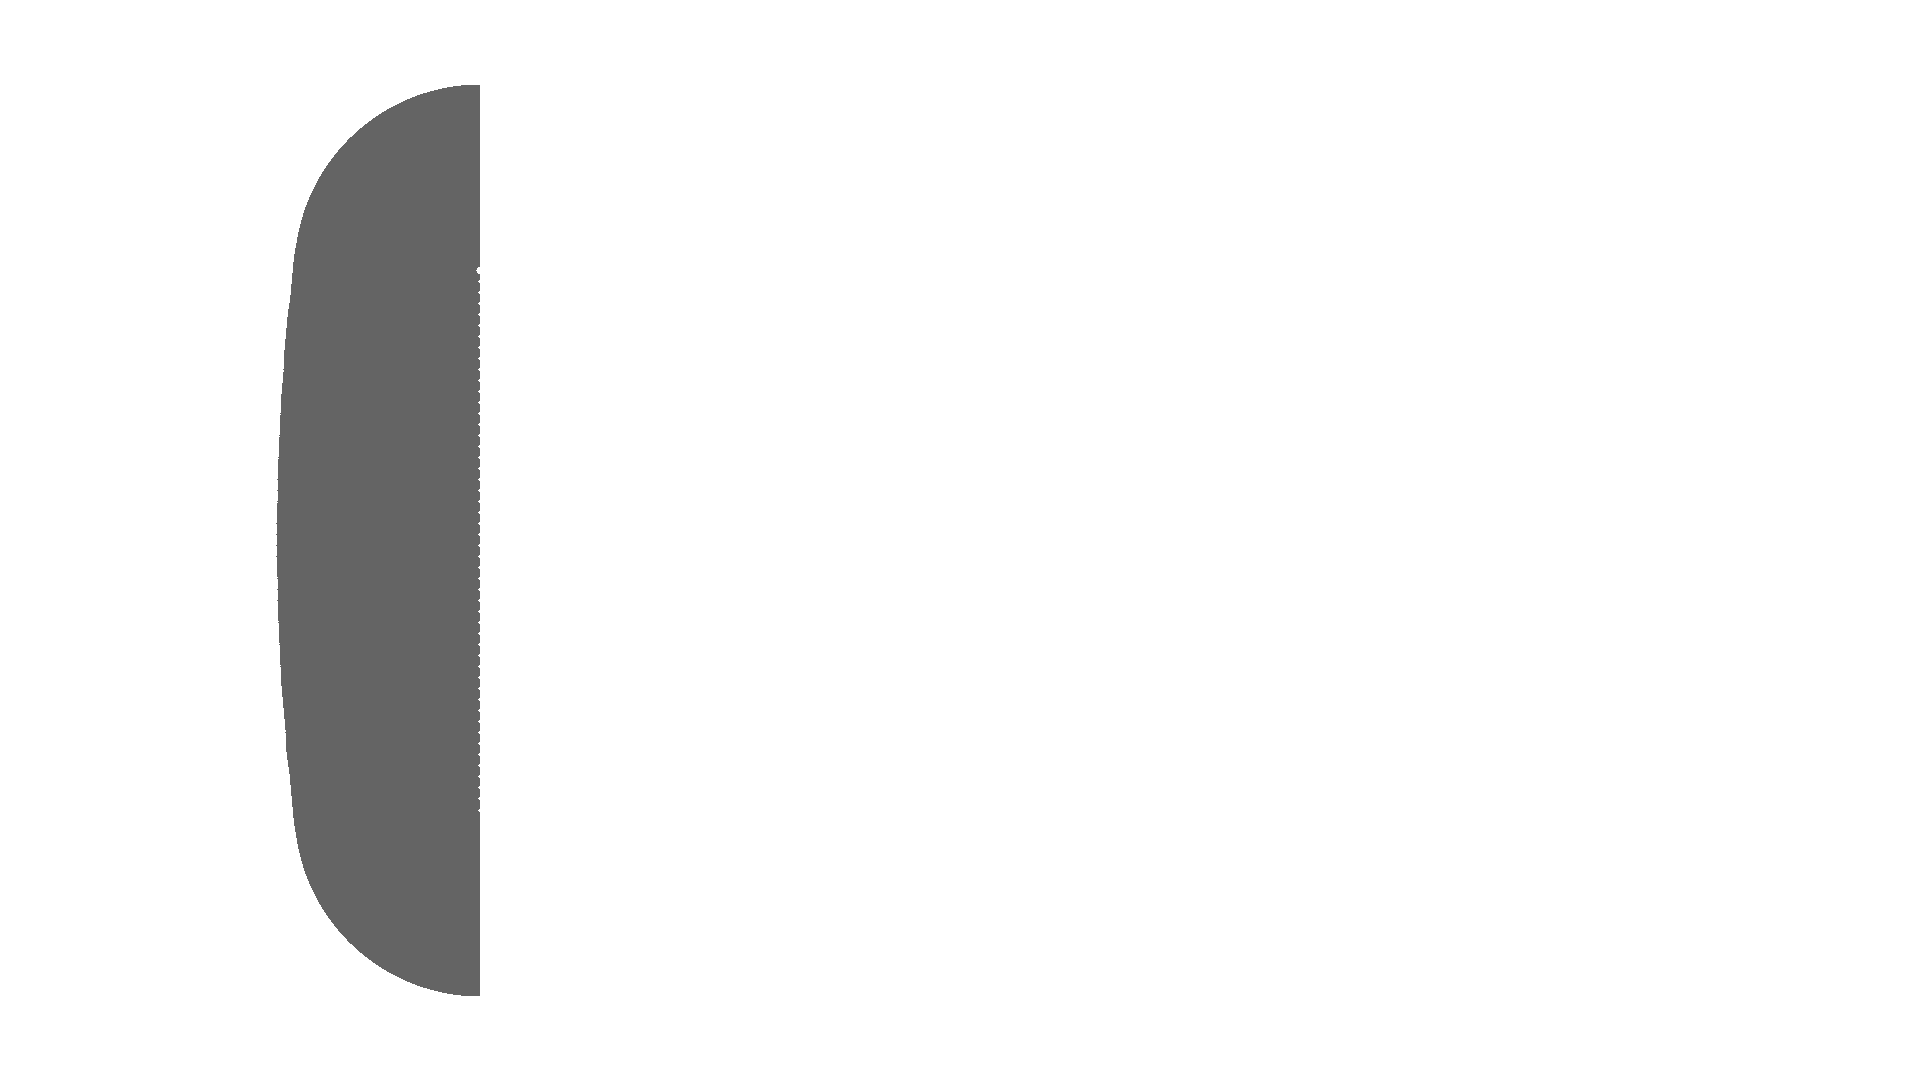

In [23]:
plain = np.ones((w,h,3))*255
plain[a==0,:] = 100
dist = np.transpose(plain, (1,0,2)).astype(np.uint8)
to_pil(dist)

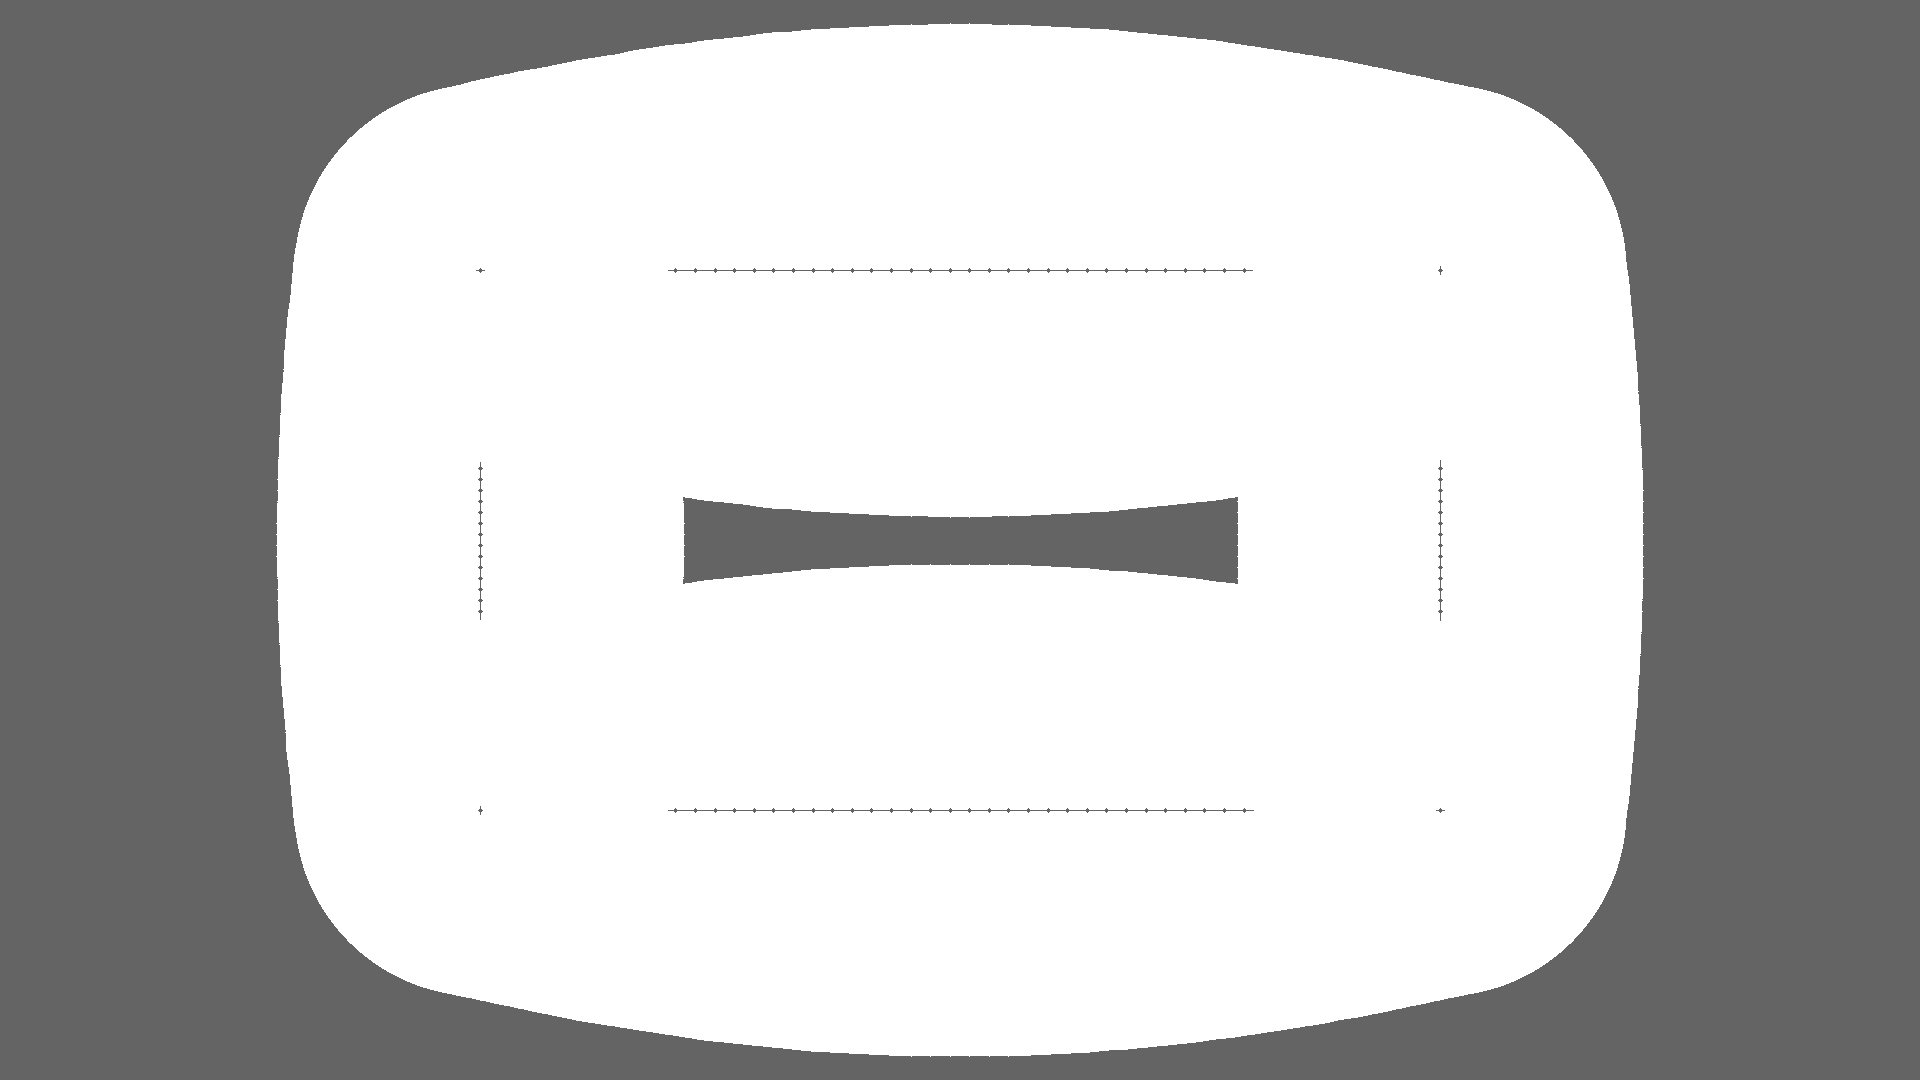

In [69]:
plank[159,254,1]

254

In [38]:
plank = np.zeros((1080, 1920)).astype(np.uint8)
plank[:, :1920//2] = 1
cv2.rectangle(plank, (0,0), (1919,1079), 2, 300)
plank = plank.T
region = np.zeros((1920, 1080))
region[plank==1] = 1
region[plank==2] = -1

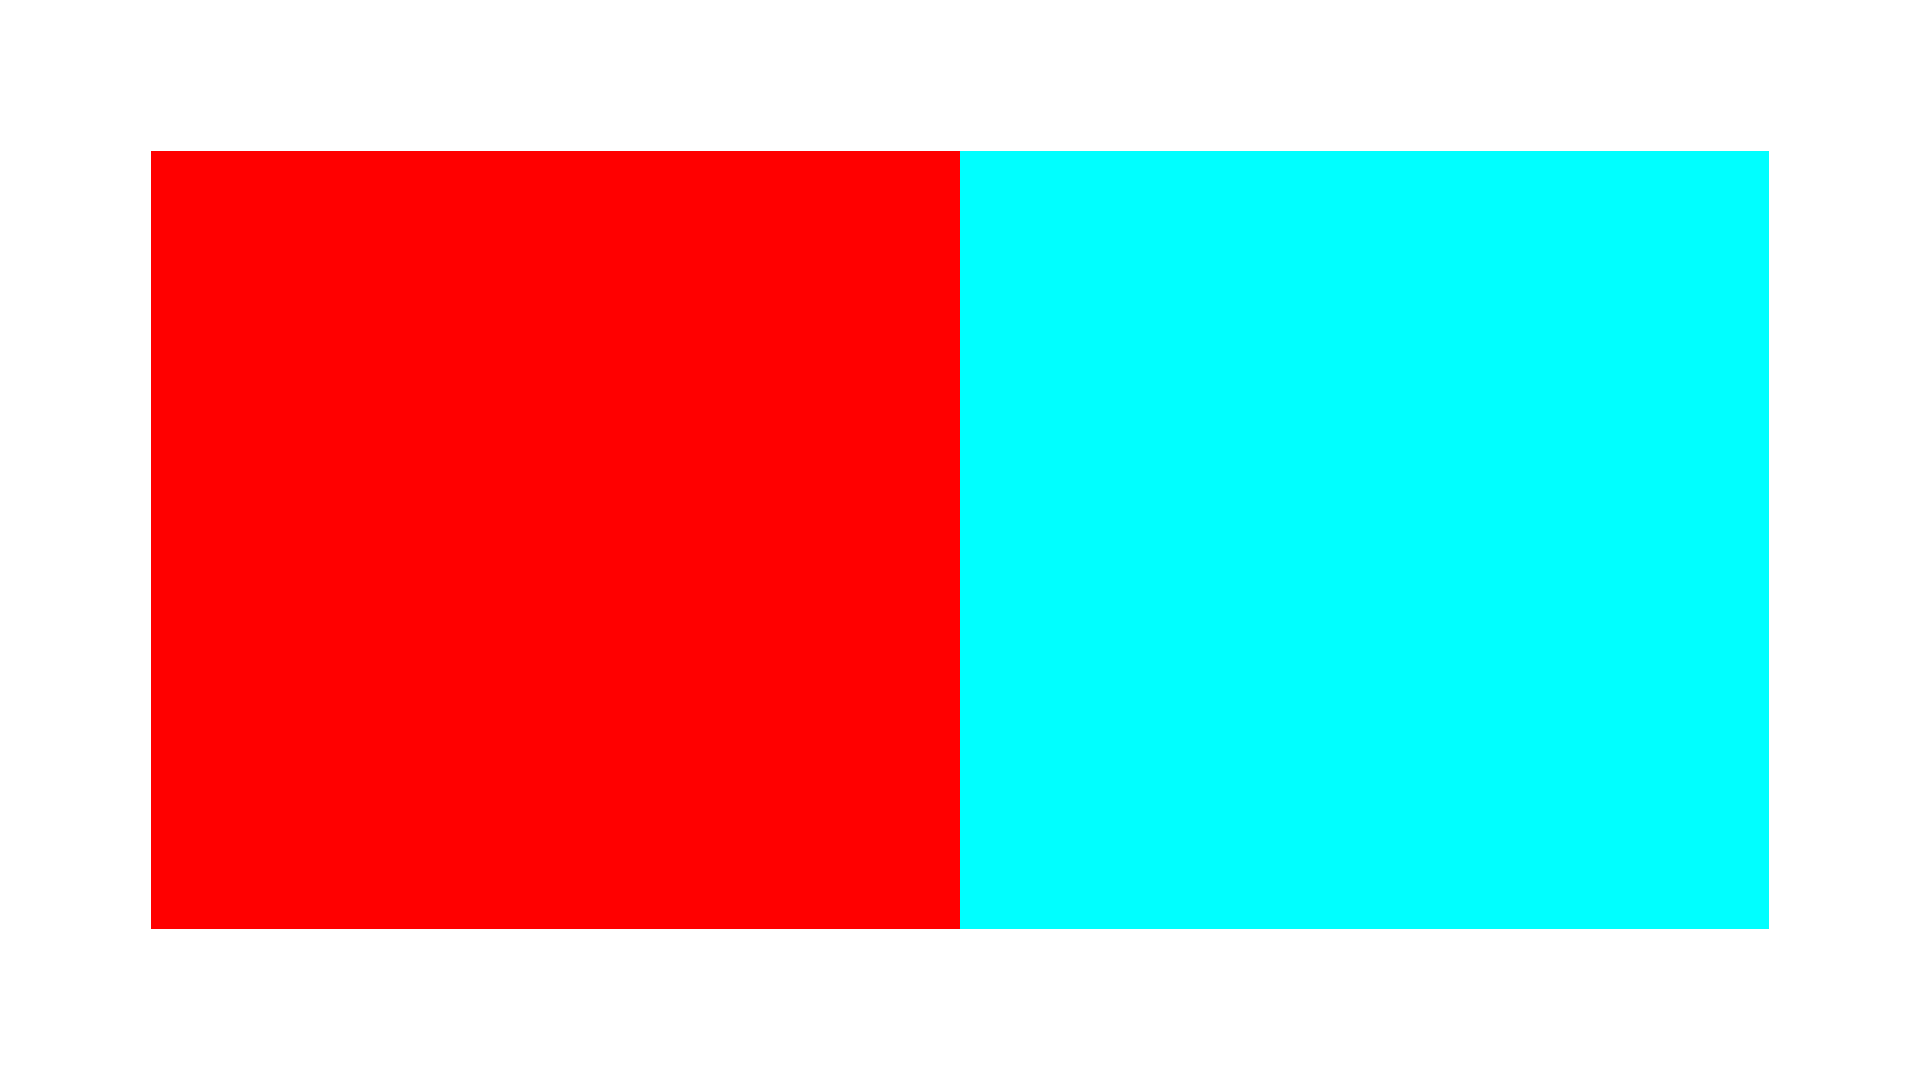

In [39]:
visualize_region(plank)

In [40]:
np.save("/home/allen/test_region.npy", region[np.newaxis, ...])

In [34]:
region_map.shape

(2, 1920, 1080)

In [13]:
from scipy.linalg.blas import dgemm

In [27]:
a = np.random.random((1,10))
b = np.random.random((9,10))

In [26]:
def dot_py(A,B):
    m, n = A.shape
    p = B.shape[1]

    C = np.zeros((m,p))

    for i in range(0,m):
        for j in range(0,p):
            for k in range(0,n):
                C[i,j] += A[i,k]*B[k,j] 
    return C

In [28]:
dot_py(a,b.T)

array([[2.50035317, 2.52107163, 1.9432782 , 1.58858713, 2.52507779,
        1.99765709, 1.8498426 , 1.30135159, 2.32857773]])

In [29]:
import numba as nb
dot_nb = nb.jit(nb.float64[:,:](nb.float64[:,:], nb.float64[:,:]), nopython = True)(dot_py)

In [32]:
dot_nb(a, b.T)

array([[2.50035317, 2.52107163, 1.9432782 , 1.58858713, 2.52507779,
        1.99765709, 1.8498426 , 1.30135159, 2.32857773]])